# Predecir el precio de cierre diario de Bitcoin

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
from tsxv.splitTrainValTest import split_train_val_test_groupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor        
from statsmodels.tsa.stattools import bds
from pathlib import Path
from joblib import dump


## Entrenamiento del modelo

In [4]:
import yfinance as yf

btc = pd.read_csv('C:/Users/elias/OneDrive/Desktop/MachineLearning/JBOOKS/btc-volatility-mlops/data/btc_1d_data_2018_to_2025.csv')

btc = btc[['Close time', 'Close']].dropna().reset_index(drop=True)
btc['Close'] = btc['Close'].astype(float)

btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))

window_size = 7 #14,21,28
btc['Volatility'] = btc['LogReturn'].rolling(window=window_size).std() * np.sqrt(365)  # Anualizada

btc = btc.dropna().reset_index(drop=True)

y_full = btc['Close'].values
volatility_full = btc['Volatility'].values

print(btc[['Close time', 'Close', 'LogReturn', 'Volatility']])

                   Close time      Close  LogReturn  Volatility
0     2018-01-08 23:59:59.999   14902.54  -0.080390    1.371899
1     2018-01-09 23:59:59.999   14400.00  -0.034303    1.237831
2     2018-01-10 23:59:59.999   14907.09   0.034609    1.261586
3     2018-01-11 23:59:59.999   13238.78  -0.118687    1.516218
4     2018-01-12 23:59:59.999   13740.01   0.037162    1.132406
...                       ...        ...        ...         ...
2582  2025-02-02 23:59:59.999   99796.00  -0.024038    0.319643
2583  2025-02-03 23:59:59.999   94495.21  -0.054579    0.486452
2584  2025-02-04 23:59:59.999  101367.77   0.070206    0.764874
2585  2025-02-05 23:59:59.999   97589.30  -0.037987    0.779201
2586  2025-02-06 23:59:59.999   98329.13   0.007552    0.776559

[2587 rows x 4 columns]


In [5]:
def rmse_by_h(y, yhat): return np.sqrt(np.mean((y - yhat)**2, axis=0))
def mae_by_h(y, yhat):  return np.mean(np.abs(y - yhat), axis=0)
def mse_by_h(y, yhat):  return np.mean((y - yhat)**2, axis=0)
def mape_by_h(y, yhat, eps=1e-8):
    denom = np.maximum(np.abs(y), eps)  # evita divisiones por cero
    return np.mean(np.abs((y - yhat) / denom), axis=0) * 100.0

In [15]:
from tsxv.splitTrainValTest import split_train_val_test_groupKFold

def rmse_by_h(true, pred):  # RMSE por horizonte (vector de largo n_steps_forecast)
    return np.sqrt(np.mean((true - pred)**2, axis=0))

lags_list = [7, 14, 21, 28]       # Diferentes ventanas a probar
n_steps_forecast = 7              # Predicción para 7 días adelante
n_steps_jump = 1                  # Saltar de a 1 ventana

results_lags = {}

for n_steps_input in lags_list:
    print(f"\n===== Usando {n_steps_input} días previos como input =====")

    # Split temporal (sin leakage)
    X, y, Xcv, ycv, Xtest, ytest = split_train_val_test_groupKFold(
        btc['Volatility'].to_numpy(),    # <-- tu serie objetivo actual
        numInputs=n_steps_input,
        numOutputs=n_steps_forecast,
        numJumps=n_steps_jump,
    )

    dict_rmse = {}          # todo por fold
    rmse_test_fold = []     # para curva RMSE por fold
    bds_p_fold = []         # p-values por fold

    for fold in range(len(X)):
        # ===== Escalado (fit SOLO con train) =====
        scaler_x = StandardScaler().fit(X[fold])
        scaler_y = StandardScaler().fit(y[fold])

        X_train = scaler_x.transform(X[fold]);     y_train = scaler_y.transform(y[fold])
        X_val   = scaler_x.transform(Xcv[fold]);   y_val   = scaler_y.transform(ycv[fold])
        X_test  = scaler_x.transform(Xtest[fold]); y_test  = scaler_y.transform(ytest[fold])

        # ===== Modelo =====
        model = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=300, random_state=fold)
        model.fit(X_train, y_train)

        # ===== Predicciones (desescaladas) =====
        yhat_train = scaler_y.inverse_transform(model.predict(X_train))
        yhat_val   = scaler_y.inverse_transform(model.predict(X_val))
        yhat_test  = scaler_y.inverse_transform(model.predict(X_test))

        ytrain_real = scaler_y.inverse_transform(y_train)
        yval_real   = scaler_y.inverse_transform(y_val)
        ytest_real  = scaler_y.inverse_transform(y_test)

        # ===== Métricas por horizonte =====
        # TRAIN
        rmse_train_h = rmse_by_h(ytrain_real, yhat_train)
        mae_train_h  = mae_by_h(ytrain_real, yhat_train)
        mse_train_h  = mse_by_h(ytrain_real, yhat_train)
        mape_train_h = mape_by_h(ytrain_real, yhat_train)

        # VAL
        rmse_val_h = rmse_by_h(yval_real, yhat_val)
        mae_val_h  = mae_by_h(yval_real, yhat_val)
        mse_val_h  = mse_by_h(yval_real, yhat_val)
        mape_val_h = mape_by_h(yval_real, yhat_val)

        # TEST
        rmse_test_h = rmse_by_h(ytest_real, yhat_test)
        mae_test_h  = mae_by_h(ytest_real, yhat_test)
        mse_test_h  = mse_by_h(ytest_real, yhat_test)
        mape_test_h = mape_by_h(ytest_real, yhat_test)

        # ===== Promedios (sobre horizontes) =====
        rmse_train = float(np.mean(rmse_train_h)); mae_train  = float(np.mean(mae_train_h))
        mse_train  = float(np.mean(mse_train_h));  mape_train = float(np.mean(mape_train_h))

        rmse_val   = float(np.mean(rmse_val_h));   mae_val    = float(np.mean(mae_val_h))
        mse_val    = float(np.mean(mse_val_h));    mape_val   = float(np.mean(mape_val_h))

        rmse_test  = float(np.mean(rmse_test_h));  mae_test   = float(np.mean(mae_test_h))
        mse_test   = float(np.mean(mse_test_h));   mape_test  = float(np.mean(mape_test_h))

        rmse_test_fold.append(rmse_test)  # para tu curva por fold (TEST)

        # ===== BDS en residuos del primer horizonte (TEST) =====
        resid_h1 = (ytest_real[:, 0] - yhat_test[:, 0]).ravel()
        res = bds(resid_h1, max_dim=2)
        try:
            pval = float(np.atleast_1d(res.pvalue)[0])   # statsmodels moderno
        except AttributeError:
            _, pvals = res
            pval = float(np.atleast_1d(pvals)[0])
        bds_p_fold.append(pval)

        # ===== Guardar TODO por fold (para tablas/plots) =====
        dict_rmse[str(fold)] = {
            # predicciones y reales
            'yhat_train': yhat_train, 'ytrain_real': ytrain_real,
            'yhat_val':   yhat_val,   'yval_real':   yval_real,
            'yhat_test':  yhat_test,  'ytest_real':  ytest_real,

            # métricas por horizonte
            'rmse_train_h': rmse_train_h, 'mae_train_h': mae_train_h, 'mse_train_h': mse_train_h, 'mape_train_h': mape_train_h,
            'rmse_val_h':   rmse_val_h,   'mae_val_h':   mae_val_h,   'mse_val_h':   mse_val_h,   'mape_val_h':   mape_val_h,
            'rmse_test_h':  rmse_test_h,  'mae_test_h':  mae_test_h,  'mse_test_h':  mse_test_h,  'mape_test_h':  mape_test_h,

            # promedios
            'rmse_train': rmse_train, 'mae_train': mae_train, 'mse_train': mse_train, 'mape_train': mape_train,
            'rmse_val':   rmse_val,   'mae_val':   mae_val,   'mse_val':   mse_val,   'mape_val':   mape_val,
            'rmse_test':  rmse_test,  'mae_test':  mae_test,  'mse_test':  mse_test,  'mape_test':  mape_test,

            # BDS
            'bds_pval_h1': pval,
            'model': model,
            'scaler_x': scaler_x,
            'scaler_y': scaler_y,
        }

    # ===== Guardar resultados agregados por lag =====
    results_lags[n_steps_input] = {
        'rmse_test_fold': rmse_test_fold,
        'rmse_test_avg': float(np.mean(rmse_test_fold)),
        'bds_p_fold': bds_p_fold,
        'bds_p_avg': float(np.mean(bds_p_fold)),
        'dict_rmse': dict_rmse
    }

    print(f"RMSE test promedio ({n_steps_input} lags): {np.mean(rmse_test_fold):.4f}")
    print(f"BDS p-valor promedio (h1): {np.mean(bds_p_fold):.4f}")



===== Usando 7 días previos como input =====
RMSE test promedio (7 lags): 0.2234
BDS p-valor promedio (h1): 0.3698

===== Usando 14 días previos como input =====
RMSE test promedio (14 lags): 0.3488
BDS p-valor promedio (h1): 0.2633

===== Usando 21 días previos como input =====
RMSE test promedio (21 lags): 0.2338
BDS p-valor promedio (h1): 0.3435

===== Usando 28 días previos como input =====
RMSE test promedio (28 lags): 0.2826
BDS p-valor promedio (h1): 0.5367


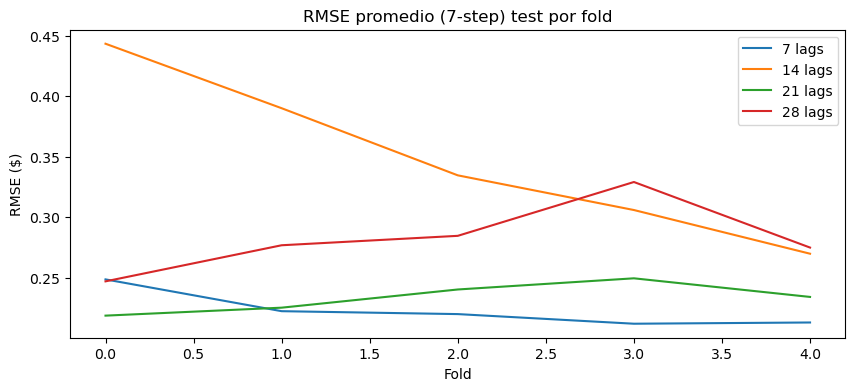

   # lags  avg RMSE test (7-step)  avg BDS p-valor (h1)
0       7                0.223376              0.369823
1      14                0.348830              0.263268
2      21                0.233751              0.343499
3      28                0.282623              0.536678


In [16]:
plt.figure(figsize=(10,4))
for n_steps_input in lags_list:
    plt.plot(results_lags[n_steps_input]['rmse_test_fold'], label=f'{n_steps_input} lags')
plt.title("RMSE promedio (7-step) test por fold")
plt.xlabel("Fold"); plt.ylabel("RMSE ($)")
plt.legend(); plt.show()

import pandas as pd

tabla_summary = pd.DataFrame(
    [[n, results_lags[n]['rmse_test_avg'], results_lags[n]['bds_p_avg']] for n in lags_list],
    columns=['# lags', 'avg RMSE test (7-step)', 'avg BDS p-valor (h1)']
)
print(tabla_summary)

In [17]:
def build_table_by_lag(results_lags, lag, n_steps_forecast, per_horizon=False, decimals=6):
    d = results_lags[lag]['dict_rmse']
    rows = []

    for f in range(len(d)):
        e = d[str(f)]
        if per_horizon:
            row = {'Fold': f+1}
            for h in range(n_steps_forecast):
                row[f'RMSE_h{h+1}'] = float(e['rmse_test_h'][h])
                row[f'MAE_h{h+1}']  = float(e['mae_test_h'][h])
                row[f'MSE_h{h+1}']  = float(e['mse_test_h'][h])
                row[f'MAPE_h{h+1}'] = float(e['mape_test_h'][h])
            row['BDS_pvalue_h1'] = float(e.get('bds_pval_h1', np.nan))
        else:
            row = {
                'Fold': f+1,
                'RMSE_avg': float(e['rmse_test']),
                'MAE_avg':  float(e['mae_test']),
                'MSE_avg':  float(e['mse_test']),
                'MAPE_avg': float(e['mape_test']),
                'BDS_pvalue_h1': float(e.get('bds_pval_h1', np.nan))
            }
        rows.append(row)

    df = pd.DataFrame(rows)

    # Fila final Mean ± Std (sobre folds)
    mean_vals = df.drop(columns=['Fold']).mean(numeric_only=True)
    std_vals  = df.drop(columns=['Fold']).std(numeric_only=True)
    mean_std  = {col: f"{mean_vals[col]:.{decimals}f} ± {std_vals[col]:.{decimals}f}" for col in mean_vals.index}
    df = pd.concat([df, pd.DataFrame([{'Fold': 'Mean ± Std', **mean_std}])], ignore_index=True)
    return df

# === ejemplo: mostrar tablas para lag=14 ===
lag_demo = 14
tabla_resumen = build_table_by_lag(results_lags, lag_demo, n_steps_forecast, per_horizon=False)
print(f"\nTabla TEST — Resumen por fold (lags={lag_demo})")
try:
    display(tabla_resumen.round(6))  # en Jupyter
except:
    print(tabla_resumen.round(6))

tabla_h = build_table_by_lag(results_lags, lag_demo, n_steps_forecast, per_horizon=True)
print(f"\nTabla TEST — Por horizonte (lags={lag_demo})")
try:
    display(tabla_h.round(6))
except:
    print(tabla_h.round(6))



Tabla TEST — Resumen por fold (lags=14)


,Fold,RMSE_avg,MAE_avg,MSE_avg,MAPE_avg,BDS_pvalue_h1
0,1,0.443336,0.222912,0.215994,38.793836,0.049544
1,2,0.390092,0.21194,0.17503,39.581479,0.000491
2,3,0.334685,0.182602,0.138001,35.094716,0.000183
3,4,0.306047,0.172553,0.116378,34.479682,0.698839
4,5,0.269988,0.202821,0.081392,42.025011,0.567284
5,Mean ± Std,0.348830 ± 0.068703,0.198566 ± 0.020744,0.145359 ± 0.052095,37.994945 ± 3.168799,0.263268 ± 0.341354



Tabla TEST — Por horizonte (lags=14)


,Fold,RMSE_h1,MAE_h1,MSE_h1,MAPE_h1,RMSE_h2,MAE_h2,MSE_h2,MAPE_h2,RMSE_h3,...,MAPE_h5,RMSE_h6,MAE_h6,MSE_h6,MAPE_h6,RMSE_h7,MAE_h7,MSE_h7,MAPE_h7,BDS_pvalue_h1
0,1,0.121395,0.085058,0.014737,17.339241,0.4095,0.177835,0.16769,28.194908,0.472179,...,42.098474,0.529068,0.277653,0.279913,52.010047,0.569863,0.315419,0.324744,50.574843,0.049544
1,2,0.12989,0.099197,0.016871,21.327431,0.186136,0.130712,0.034647,25.928352,0.416402,...,48.04125,0.51547,0.275738,0.26571,46.381841,0.528244,0.286159,0.279041,54.157836,0.000491
2,3,0.117092,0.085038,0.013711,18.874002,0.15915,0.106267,0.025329,24.193042,0.181427,...,44.86387,0.492146,0.251908,0.242208,47.27975,0.514648,0.272298,0.264863,46.071655,0.000183
3,4,0.141658,0.10055,0.020067,18.165408,0.176101,0.136586,0.031012,26.314687,0.183576,...,38.884987,0.494289,0.230287,0.244322,46.504848,0.500736,0.242471,0.250737,46.701661,0.698839
4,5,0.142467,0.105814,0.020297,23.733753,0.171607,0.132216,0.029449,31.587907,0.212065,...,50.048022,0.359551,0.264211,0.129277,50.137546,0.412939,0.299986,0.170518,60.296834,0.567284
5,Mean ± Std,0.130500 ± 0.011519,0.095131 ± 0.009531,0.017136 ± 0.003006,19.887967 ± 2.615027,0.220499 ± 0.106098,0.136723 ± 0.025856,0.057625 ± 0.061619,27.243779 ± 2.814101,0.293130 ± 0.139916,...,44.787320 ± 4.481527,0.478105 ± 0.068021,0.259960 ± 0.019528,0.232286 ± 0.059665,48.462807 ± 2.497564,0.505286 ± 0.057736,0.283266 ± 0.027867,0.257981 ± 0.056237,51.560566 ± 5.868921,0.263268 ± 0.341354


In [18]:
total_modelos = 0
for lag in lags_list:
    X, y, Xcv, ycv, Xtest, ytest = split_train_val_test_groupKFold(
        btc['Volatility'].to_numpy(),
        numInputs=lag,
        numOutputs=n_steps_forecast,
        numJumps=n_steps_jump
    )
    k = len(X)
    print(f"Lags={lag}: folds={k}")
    total_modelos += k

print("Total de modelos entrenados:", total_modelos)


Lags=7: folds=5
Lags=14: folds=5
Lags=21: folds=5
Lags=28: folds=5
Total de modelos entrenados: 20


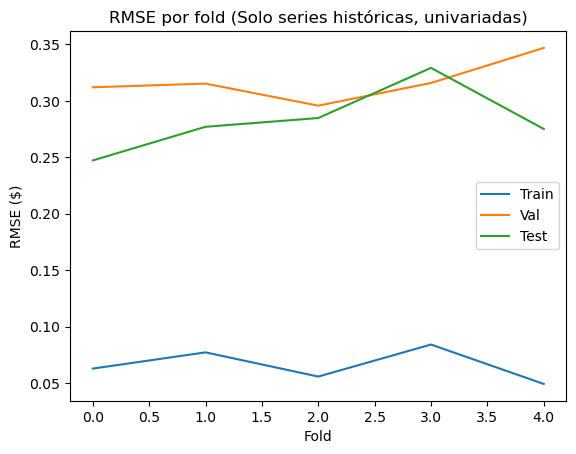

In [19]:
rmse_train_list = [dict_rmse[str(i)]['rmse_train'] for i in range(len(dict_rmse))]
rmse_val_list = [dict_rmse[str(i)]['rmse_val'] for i in range(len(dict_rmse))]
rmse_test_list = [dict_rmse[str(i)]['rmse_test'] for i in range(len(dict_rmse))]

plt.plot(rmse_train_list, label='Train')
plt.plot(rmse_val_list, label='Val')
plt.plot(rmse_test_list, label='Test')
plt.xlabel('Fold')
plt.ylabel('RMSE ($)')
plt.title("RMSE por fold (Solo series históricas, univariadas)")
plt.legend()
plt.show()

In [20]:
artifacts = {
    "lags_list": [7,14,21,28],
    "n_steps_forecast": 7,
    "results_lags": results_lags,   # contiene por fold: yhat_train/val/test, y*_real, métricas, bds_pval_h1
    # opcional: guarda también hiperparámetros, fecha, versión, etc.
    "meta": {"target": "Volatility", "model": "MLPRegressor(64,32)"}
}

Path("artifacts").mkdir(exist_ok=True)
dump(artifacts, "artifacts/training_artifacts.joblib")
print("Artefactos de entrenamiento guardados en artifacts/training_artifacts.joblib")

Artefactos de entrenamiento guardados en artifacts/training_artifacts.joblib


In [31]:
from joblib import dump
from pathlib import Path
import numpy as np

Path("C:/Users/elias/OneDrive/Desktop/MachineLearning/JBOOKS/btc-volatility-mlops/app").mkdir(parents=True, exist_ok=True)

def export_artifacts_per_lag(results_lags, lags_list, horizon=7, target="Volatility"):
    for lag in lags_list:
        d = results_lags[lag]['dict_rmse']            # dict por fold
        fold_ids = sorted(map(int, d.keys()))
        # elige el mejor fold por RMSE test (promedio sobre horizontes)
        rmse_test_list = [float(d[str(i)]['rmse_test']) for i in fold_ids]
        best_fold = int(np.argmin(rmse_test_list))

        art = {
            "model":    d[str(best_fold)]['model'],
            "scaler_x": d[str(best_fold)]['scaler_x'],
            "scaler_y": d[str(best_fold)]['scaler_y'],
            "config": {
                "lags": lag,
                "horizon": horizon,
                "target": target,
                "selected": {"fold": best_fold, "rmse_test": float(rmse_test_list[best_fold])},
                "model_name": "MLPRegressor(64,32)"
            }
        }
        out_path = f"C:/Users/elias/OneDrive/Desktop/MachineLearning/JBOOKS/btc-volatility-mlops/app/model_lag{lag}.joblib"
        dump(art, out_path)
        print(f"[OK] Exportado: {out_path} (best fold={best_fold}, RMSE={rmse_test_list[best_fold]:.4f})")

# úsalo así:
export_artifacts_per_lag(results_lags, lags_list=[7,14,21,28], horizon=7, target="Volatility")



[OK] Exportado: C:/Users/elias/OneDrive/Desktop/MachineLearning/JBOOKS/btc-volatility-mlops/app/model_lag7.joblib (best fold=3, RMSE=0.2122)
[OK] Exportado: C:/Users/elias/OneDrive/Desktop/MachineLearning/JBOOKS/btc-volatility-mlops/app/model_lag14.joblib (best fold=4, RMSE=0.2700)
[OK] Exportado: C:/Users/elias/OneDrive/Desktop/MachineLearning/JBOOKS/btc-volatility-mlops/app/model_lag21.joblib (best fold=0, RMSE=0.2189)
[OK] Exportado: C:/Users/elias/OneDrive/Desktop/MachineLearning/JBOOKS/btc-volatility-mlops/app/model_lag28.joblib (best fold=0, RMSE=0.2472)
